In [4]:
!pip install torch torch-geometric scikit-learn matplotlib seaborn

In [ ]:
import os
import pandas as pd
import numpy as np
from nilearn import maskers
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
import requests
import tarfile
import io
import glob

# --- CONFIGURATION ---
DATASET_ROOT = r'C:\Users\T2430431\Downloads\RawDataBIDS'
OUTPUT_FILE = r'C:\Users\T2430431\Downloads\RawDataBIDS\adhd_deepfmri_aal.npy'
ATLAS_DIR = r'C:\Users\T2430431\Downloads\Atlas_Cache'
N_JOBS = -1
TARGET_LENGTH = 172

# --- STEP 1: ATLAS SETUP (MANUAL LOCAL LOAD) ---
if not os.path.exists(ATLAS_DIR):
    os.makedirs(ATLAS_DIR)

# Try to locate the .nii file recursively in the cache
found_atlas = glob.glob(os.path.join(ATLAS_DIR, '**', 'ROI_MNI_V4.nii'), recursive=True)

if not found_atlas:
    print("Atlas not found. Downloading Classic AAL (SSL Verify=False)...")
    url = "https://www.gin.cnrs.fr/wp-content/uploads/aal_for_SPM12.tar.gz"
    try:
        response = requests.get(url, verify=False, stream=True)
        response.raise_for_status()
        with tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz") as tar:
            tar.extractall(path=ATLAS_DIR)
        print("Download successful!")
        found_atlas = glob.glob(os.path.join(ATLAS_DIR, '**', 'ROI_MNI_V4.nii'), recursive=True)
    except Exception as e:
        print(f"Download failed: {e}")
        exit()

if not found_atlas:
    print("CRITICAL ERROR: ROI_MNI_V4.nii still not found after download.")
    exit()

aal_nii_path = found_atlas[0]
print(f"Using Atlas: {aal_nii_path}")

# --- STEP 2: MASKER SETUP ---
masker = maskers.NiftiLabelsMasker(
    labels_img=aal_nii_path,
    standardize="zscore_sample",
    smoothing_fwhm=6,          # 6mm smoothing
    low_pass=0.08,             # f < 0.08Hz
    high_pass=0.009,           # f > 0.009Hz
    t_r=2.0,                   # Default TR
    detrend=True,
    verbose=0
)

# --- STEP 3: PROCESSING FUNCTION ---
def process_subject(row_data):
    site_path, participant_id, dx_raw, gender_raw, age_raw, iq_raw, tr_val = row_data

    try:
        sub_id = str(participant_id)
        # Handle "sub-001" vs "001" variations
        formatted_sub_id = f"sub-{sub_id.zfill(7)}" if not sub_id.startswith('sub-') else sub_id

        # BIDS PATH FIX: Search recursively for the bold file inside the subject folder
        subject_dir = os.path.join(site_path, formatted_sub_id)

        fmri_path = None
        if os.path.exists(subject_dir):
            # Recursive search for any file ending in 'bold.nii.gz'
            # This finds 'sub-1018959_ses-1_task-rest_acq-1_run-1_bold.nii.gz'
            # regardless of ses-1 or func folders.
            bold_files = glob.glob(os.path.join(subject_dir, '**', '*bold.nii.gz'), recursive=True)
            if bold_files:
                fmri_path = bold_files[0] # Take the first bold file found

        if not fmri_path: return None

        # Assign Labels
        label = 0
        val = str(dx_raw).lower()
        if any(x in val for x in ["typically", "control", "td", "0"]):
            label = 0
        elif any(x in val for x in ["adhd", "1", "2", "3"]):
            label = 1
        else:
            return None

        # Extract Time Series
        masker.t_r = tr_val

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # AAL extracts 116 regions usually
            full_time_series = masker.fit_transform(fmri_path)

        # Enforce Fixed Length
        n_time_points, n_regions = full_time_series.shape

        if n_time_points < TARGET_LENGTH:
            return None

        final_time_series = full_time_series[:TARGET_LENGTH, :]

        # SLICE TO 90 REGIONS (Paper requirement)
        if n_regions >= 90:
            final_time_series = final_time_series[:, :90]
        else:
            return None

        # Extract Phenotypes
        gender = 0 if str(gender_raw).lower() == 'male' else 1
        try: age = float(age_raw)
        except: age = 0.0
        try: iq = float(iq_raw)
        except: iq = 100.0
        if np.isnan(iq): iq = 100.0

        return {
            'time_series': final_time_series.astype(np.float32),
            'pheno': [age, gender, iq],
            'label': label,
            'site': os.path.basename(site_path)
        }

    except Exception as e:
        return None

if __name__ == "__main__":
    # Site TR configuration (NYU=2.0, NeuroIMAGE=1.96, etc.)
    site_config = {
        'NYU': 2.0, 'NeuroIMAGE': 1.96, 'Peking_1': 2.0, 'Peking_2': 2.0, 'Peking_3': 2.0,
        'KKI': 2.5, 'OHSU': 2.5, 'WashU': 2.5, 'Pittsburgh': 1.5
    }

    tasks = []

    print("Scanning dataset directories...")
    for site, tr in site_config.items():
        site_path = os.path.join(DATASET_ROOT, site)
        # Note: Your debug output showed phenotypic files are named 'KKI_phenotypic.csv'
        # We need to detect either .tsv or .csv
        possible_phenos = [
            os.path.join(site_path, 'participants.tsv'),
            os.path.join(DATASET_ROOT, f"{site}_phenotypic.csv")
        ]

        pheno_file = None
        for p in possible_phenos:
            if os.path.exists(p):
                pheno_file = p
                break

        if not pheno_file:
            print(f"Skipping {site}: No phenotypic file found.")
            continue

        try:
            # Handle CSV vs TSV
            if pheno_file.endswith('.tsv'):
                df = pd.read_csv(pheno_file, sep='\t', encoding_errors='replace')
            else:
                df = pd.read_csv(pheno_file, encoding_errors='replace')

            df.columns = [c.lower() for c in df.columns]

            # Find diagnosis column
            target_col = next((c for c in ['dx', 'diagnosis', 'adhd_status', 'group'] if c in df.columns), None)
            # Find subject ID column (sometimes it's 'scanDir_ID' or 'Subject')
            id_col = next((c for c in ['participant_id', 'scandir_id', 'subject'] if c in df.columns), None)

            if not target_col or not id_col:
                print(f"Skipping {site}: Columns missing in {os.path.basename(pheno_file)}")
                continue

            for _, row in df.iterrows():
                # Handle IQ (optional)
                iq_val = np.nan
                if 'iq' in df.columns: iq_val = row['iq']
                elif 'verbal_iq' in df.columns: iq_val = row['verbal_iq']

                # Handle Gender (optional)
                gender_val = row['gender'] if 'gender' in df.columns else '0'

                tasks.append((
                    site_path,
                    row[id_col],
                    row[target_col],
                    gender_val,
                    row['age'] if 'age' in df.columns else 0,
                    iq_val,
                    tr
                ))
        except Exception as e:
            print(f"Error preparing {site}: {e}")

    print(f"Found {len(tasks)} potential scans.")
    print(f"Starting Processing (Target Length: {TARGET_LENGTH}, Atlas: AAL 90)...")

    results = Parallel(n_jobs=N_JOBS, backend='loky')(
        delayed(process_subject)(t) for t in tqdm(tasks, unit="scan")
    )

    valid_results = [r for r in results if r is not None]

    print(f"\nProcessing Complete!")
    print(f"Successfully processed: {len(valid_results)} subjects")

    np.save(OUTPUT_FILE, valid_results)
    print(f"Saved to {OUTPUT_FILE}")

    if len(valid_results) > 0:
        print(f"Shape check: {valid_results[0]['time_series'].shape}")

# Found 1036 potential scans.
# Starting Processing (Target Length: 172, Atlas: AAL 90)
# Processing Complete!
# Successfully processed: 637 subjects
# ==============================
#       SANITY CHECK REPORT
# ==============================
# [PASS] All 637 subjects have shape (172, 90)
# [PASS] No NaNs or Infinite values found.

# --- Class Distribution ---
# Healthy (0): 362
# ADHD    (1): 275

# --- Site Distribution ---
# NYU: 201
# NeuroIMAGE: 57
# Peking_1: 187
# Peking_2: 65
# Peking_3: 42
# Pittsburgh: 85

Using device: cuda
Loading data from /content/drive/MyDrive/adhd_deepfmri_aal.npy...
Converting Time-Series to Graphs...


/tmp/ipython-input-93597419.py:280: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
/tmp/ipython-input-93597419.py:281: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
/tmp/ipython-input-93597419.py:282: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



Data Split: Train (432), Val (77), Test (128)
Class Imbalance Correction: pos_weight = 1.31

--- Starting Training ---
Epoch 001: Train Loss: 0.7892 | Val Loss: 0.7803 | Val Acc: 0.5195 | Val AUC: 0.5152
Epoch 002: Train Loss: 0.7720 | Val Loss: 0.7694 | Val Acc: 0.6104 | Val AUC: 0.6384
Epoch 003: Train Loss: 0.7571 | Val Loss: 0.7583 | Val Acc: 0.6364 | Val AUC: 0.6364
Epoch 004: Train Loss: 0.7524 | Val Loss: 0.7512 | Val Acc: 0.6364 | Val AUC: 0.6302
Epoch 005: Train Loss: 0.7595 | Val Loss: 0.7445 | Val Acc: 0.6364 | Val AUC: 0.6433
Epoch 006: Train Loss: 0.7401 | Val Loss: 0.7378 | Val Acc: 0.6104 | Val AUC: 0.6288
Epoch 007: Train Loss: 0.7372 | Val Loss: 0.7316 | Val Acc: 0.6234 | Val AUC: 0.6439
Epoch 008: Train Loss: 0.7441 | Val Loss: 0.7241 | Val Acc: 0.6234 | Val AUC: 0.6618
Epoch 009: Train Loss: 0.7329 | Val Loss: 0.7252 | Val Acc: 0.6234 | Val AUC: 0.6453
Epoch 010: Train Loss: 0.7243 | Val Loss: 0.7219 | Val Acc: 0.6234 | Val AUC: 0.6715
Epoch 011: Train Loss: 0.7190 

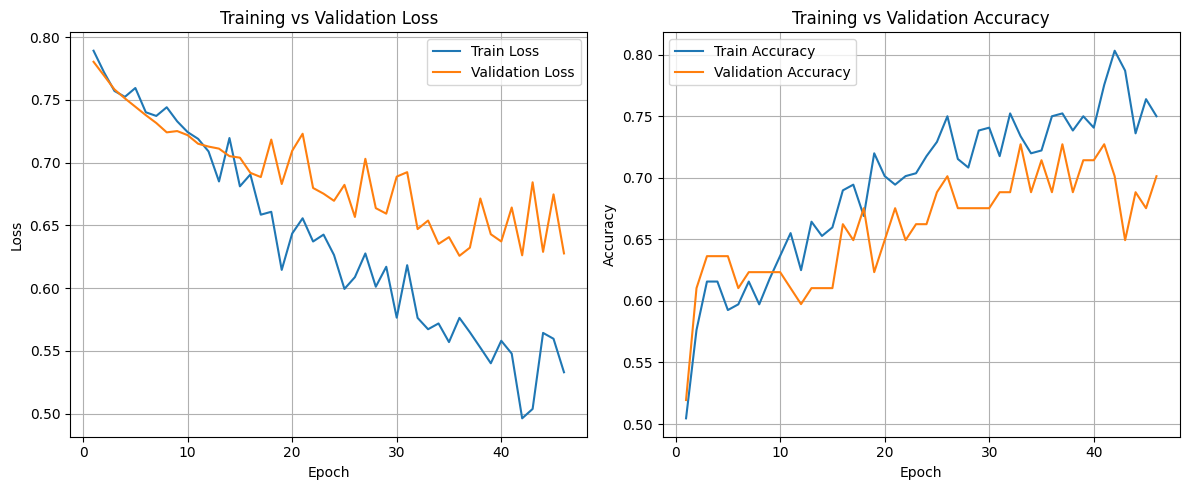

Learning curves saved to adhd_learning_curves.png

--- Final Evaluation on Test Set ---

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.71      0.74        73
        ADHD       0.65      0.71      0.68        55

    accuracy                           0.71       128
   macro avg       0.71      0.71      0.71       128
weighted avg       0.72      0.71      0.71       128



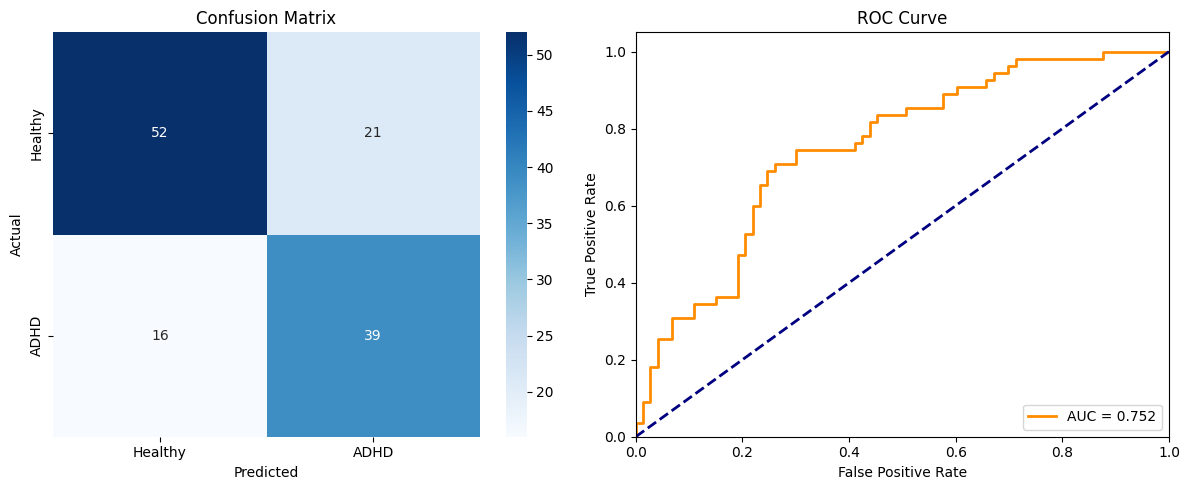

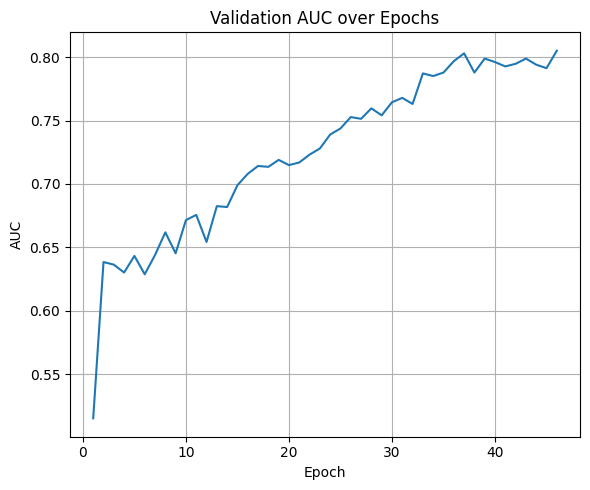


SUMMARY REPORT
Configuration: Fixed Correlation Threshold
Graph Construction: |r| > 0.6
Data Augmentation: Disabled
Best Validation Accuracy: 0.6883
Final Test Accuracy: 0.7109
ROC-AUC Score: 0.7517
Average Precision: 0.6763
F1-Score: 0.6783
Total Training Graphs: 432
Total Test Graphs: 128
Model Parameters: 17,793
Training Epochs Completed: 36
Results saved to adhd_evaluation_results.png


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from sklearn.metrics import average_precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, accuracy_score, precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- CONFIGURATION ---
DATA_PATH = '/content/drive/MyDrive/adhd_deepfmri_aal.npy'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4  # L2 Regularization
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
DROPOUT_RATE = 0.5
HIDDEN_CHANNELS = 32
NUM_HEADS = 4
CORRELATION_THRESHOLD = 0.6  # Threshold to create edges in the graph
SEED = 42

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- STEP 1: DATASET CLASS ---

class ADHDGraphDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None, pre_transform=None):
        super(ADHDGraphDataset, self).__init__('.', transform, pre_transform)
        self.data, self.slices = self.collate(data_list)

    def _download(self):
        pass

    def _process(self):
        pass

def create_graph_data(npy_path, threshold=0.5):
    print(f"Loading data from {npy_path}...")
    if not os.path.exists(npy_path):
        raise FileNotFoundError(f"File not found at {npy_path}")

    raw_data = np.load(npy_path, allow_pickle=True)

    # 1. Phenotypic Preprocessing
    # Extract pheno features to normalize them
    pheno_matrix = np.array([item['pheno'] for item in raw_data])
    scaler = StandardScaler()
    pheno_normalized = scaler.fit_transform(pheno_matrix)

    data_list = []

    print("Converting Time-Series to Graphs...")
    for idx, item in enumerate(raw_data):
        # A. Functional Connectivity (Pearson Correlation)
        # item['time_series'] shape: (172, 90) -> Transpose to (90, 172) for correlation
        ts = item['time_series'].T
        # Add small epsilon to avoid division by zero
        correlation_matrix = np.corrcoef(ts)
        np.nan_to_num(correlation_matrix, copy=False, nan=0.0)

        # B. Node Features
        # In fMRI GNNs, the node feature is often the correlation profile itself (row of the matrix)
        # Shape: [90 nodes, 90 features]
        x = torch.tensor(correlation_matrix, dtype=torch.float)

        # C. Edge Construction (Thresholding)
        # We only keep edges where absolute correlation > threshold
        # We exclude self-loops (diagonal) by subtracting identity
        adj = np.abs(correlation_matrix)
        adj = adj - np.eye(adj.shape[0])
        edge_indices = np.where(adj > threshold)

        edge_index = torch.tensor(np.array(edge_indices), dtype=torch.long)

        # Edge Weights (Optional: Correlation strength)
        edge_attr = torch.tensor(adj[edge_indices], dtype=torch.float)

        # D. Target & Pheno
        y = torch.tensor([item['label']], dtype=torch.long) # 0 or 1
        pheno = torch.tensor([pheno_normalized[idx]], dtype=torch.float) # [1, 3]

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, pheno=pheno)
        data_list.append(data)

    return data_list

# --- STEP 2: MODEL DEFINITION (GAT + MLP) ---

class GAT_Pheno_Model(nn.Module):
    def __init__(self, num_node_features, num_pheno_features, hidden_channels, num_heads, dropout):
        super(GAT_Pheno_Model, self).__init__()

        # --- GNN Branch (Brain) ---
        # Head 1
        self.gat1 = GATConv(num_node_features, hidden_channels, heads=num_heads, dropout=dropout)
        # Head 2 (Input is hidden * heads)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=False, dropout=dropout)

        # --- MLP Branch (Phenotypes) ---
        self.pheno_mlp = nn.Sequential(
            nn.Linear(num_pheno_features, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # --- Fusion & Classifier ---
        # GAT output (hidden) + Pheno output (16)
        combined_dim = hidden_channels + 16

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1) # Binary output (Logits)
        )

        self.dropout_val = dropout

    def forward(self, data):
        x, edge_index, batch, pheno = data.x, data.edge_index, data.batch, data.pheno

        # 1. GAT Forward
        x = F.dropout(x, p=self.dropout_val, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout_val, training=self.training)
        x = self.gat2(x, edge_index)

        # 2. Global Pooling (Readout)
        # Combines node embeddings into a single graph embedding
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Pheno Forward
        # pheno shape comes in as [batch_size, 1, 3], squeeze needed -> [batch_size, 3]
        pheno = pheno.squeeze(1)
        p = self.pheno_mlp(pheno)

        # 4. Concatenation
        combined = torch.cat([x, p], dim=1)

        # 5. Final Classification
        out = self.classifier(combined)
        return out

# --- STEP 3: TRAINING UTILITIES ---

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data)
        loss = criterion(out, data.y.float().unsqueeze(1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs

        probs = torch.sigmoid(out)
        preds = (probs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    return total_loss / len(loader.dataset), accuracy_score(all_labels, all_preds)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y.float().unsqueeze(1))
            total_loss += loss.item() * data.num_graphs

            probs = torch.sigmoid(out)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    labels_np = np.array(all_labels).flatten()
    probs_np = np.array(all_probs).flatten()

    # Handle edge case: only one class in batch
    if len(np.unique(labels_np)) > 1:
        auc = roc_auc_score(labels_np, probs_np)
    else:
        auc = np.nan

    metrics = {
        'loss': total_loss / len(loader.dataset),
        'accuracy': accuracy_score(labels_np, np.array(all_preds).flatten()),
        'auc': auc,
        'probs': probs_np,
        'preds': np.array(all_preds).flatten(),
        'labels': labels_np
    }

    return metrics

def plot_learning_curves(history, save_path="learning_curves.png"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    print(f"Learning curves saved to {save_path}")

# --- STEP 4: MAIN EXECUTION ---

def main():
    # 1. Load and Prepare Data
    try:
        graph_list = create_graph_data(DATA_PATH, threshold=CORRELATION_THRESHOLD)
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # 2. Stratified Split (Train/Val/Test)
    labels = [data.y.item() for data in graph_list]
    train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=SEED)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.15, stratify=[labels[i] for i in train_idx], random_state=SEED)

    train_dataset = [graph_list[i] for i in train_idx]
    val_dataset = [graph_list[i] for i in val_idx]
    test_dataset = [graph_list[i] for i in test_idx]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"\nData Split: Train ({len(train_dataset)}), Val ({len(val_dataset)}), Test ({len(test_dataset)})")

    # 3. Compute Class Weights (for Imbalance)
    train_labels = [data.y.item() for data in train_dataset]
    n_neg = train_labels.count(0)
    n_pos = train_labels.count(1)
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float).to(device)
    print(f"Class Imbalance Correction: pos_weight = {pos_weight.item():.2f}")

    # 4. Initialize Model
    # Node features = 90 (Correlation row size)
    # Pheno features = 3 (Age, Gender, IQ)
    model = GAT_Pheno_Model(
        num_node_features=90,
        num_pheno_features=3,
        hidden_channels=HIDDEN_CHANNELS,
        num_heads=NUM_HEADS,
        dropout=DROPOUT_RATE
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # 5. Training Loop with Early Stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_val_acc = 0.0
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}


    print("\n--- Starting Training ---")
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_metrics = evaluate(model, val_loader, criterion)
        history['val_auc'].append(val_metrics['auc'])

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_metrics['accuracy'])

        scheduler.step(val_metrics['loss'])

        print(
            f"Epoch {epoch+1:03d}: "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_metrics['loss']:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f} | "
            f"Val AUC: {val_metrics['auc']:.4f}"
        )


        # Early Stopping Check
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_val_acc = val_metrics['accuracy']
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_adhd_gat_model.pth')
            patience_counter = 0

        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping triggered.")
                break

    # ---- Plot Learning Curves ----
    plot_learning_curves(history, save_path="adhd_learning_curves.png")


    # 6. Final Evaluation
    print("\n--- Final Evaluation on Test Set ---")
    model.load_state_dict(torch.load('best_adhd_gat_model.pth'))
    test_metrics = evaluate(model, test_loader, criterion)
    # Additional test metrics
    test_auc = roc_auc_score(test_metrics['labels'], test_metrics['probs'])
    test_ap = average_precision_score(test_metrics['labels'], test_metrics['probs'])
    test_f1 = f1_score(test_metrics['labels'], test_metrics['preds'])


    # 7. Visualization & Reporting
    y_true = test_metrics['labels']
    y_pred = test_metrics['preds']
    y_probs = test_metrics['probs']

    # Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'ADHD']))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'ADHD'], yticklabels=['Healthy', 'ADHD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # ROC Curve Plot
    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig('adhd_evaluation_results.png')
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(history['val_auc']) + 1), history['val_auc'])
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation AUC over Epochs')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("val_auc_curve.png")
    plt.show()
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\nSUMMARY REPORT")
    print("=" * 80)
    print(f"Configuration: Fixed Correlation Threshold")
    print(f"Graph Construction: |r| > {CORRELATION_THRESHOLD}")
    print(f"Data Augmentation: Disabled")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"ROC-AUC Score: {test_auc:.4f}")
    print(f"Average Precision: {test_ap:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"Total Training Graphs: {len(train_dataset)}")
    print(f"Total Test Graphs: {len(test_dataset)}")
    print(f"Model Parameters: {num_params:,}")
    print(f"Training Epochs Completed: {best_epoch}")
    print("=" * 80)



    print(f"Results saved to adhd_evaluation_results.png")

if __name__ == "__main__":
    main()

# Ablation Study

/tmp/ipython-input-721461026.py:226: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader([graph_list[i] for i in train_idx], batch_size=BATCH_SIZE, shuffle=True)
/tmp/ipython-input-721461026.py:227: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader([graph_list[i] for i in val_idx], batch_size=BATCH_SIZE, shuffle=False)
/tmp/ipython-input-721461026.py:228: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader([graph_list[i] for i in test_idx], batch_size=BATCH_SIZE, shuffle=False)



==================== Running Ablation: Full Hybrid Model ====================
Result [Full Hybrid Model]: Accuracy=0.6953, AUC=0.7579

==================== Running Ablation: Brain Only (GAT) ====================
Result [Brain Only (GAT)]: Accuracy=0.6250, AUC=0.6057

==================== Running Ablation: Pheno Only (MLP) ====================
Result [Pheno Only (MLP)]: Accuracy=0.6562, AUC=0.7098

ABLATION STUDY RESULTS (Copy to Paper)
Model Variant        | Accuracy   | AUC-ROC    | F1-Score   | Precision 
----------------------------------------------------------------------
Full (GAT+Pheno)     | 0.6953     | 0.7579     | 0.6549     | 0.6909    
Brain Only (GAT)     | 0.6250     | 0.6057     | 0.6190     | 0.5556    
Pheno Only (MLP)     | 0.6562     | 0.7098     | 0.6667     | 0.5968    
----------------------------------------------------------------------

[INFO] Comparison chart saved to 'ablation_comparison.png'

--- Detailed Confusion Matrix (Full Model) ---
              pre

<Figure size 1000x600 with 0 Axes>

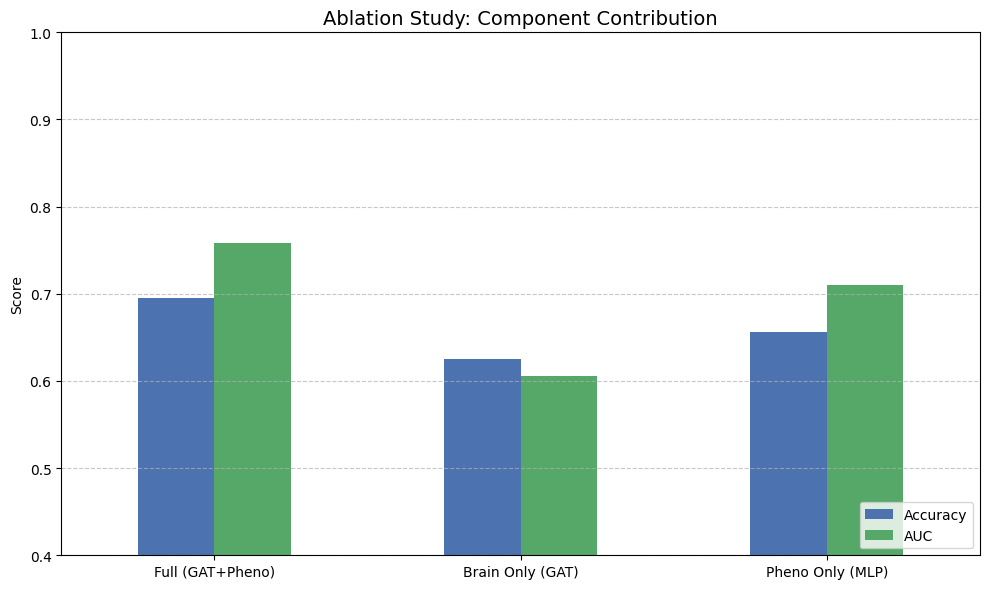

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score,
                             accuracy_score, f1_score, average_precision_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Import reporting tools
try:
    from adhd_reporting_utils import print_detailed_confusion_matrix
except ImportError:
    print("Warning: adhd_reporting_utils.py not found. Some detailed tables may be skipped.")

# --- CONFIGURATION ---
DATA_PATH = '/content/drive/MyDrive/adhd_deepfmri_aal.npy'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4
EPOCHS = 60 # Reduced slightly for ablation speed, increase for final run
EARLY_STOPPING_PATIENCE = 10
DROPOUT_RATE = 0.5
HIDDEN_CHANNELS = 32
NUM_HEADS = 4
CORRELATION_THRESHOLD = 0.6
SEED = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- DATA LOADING (Reused) ---
def create_graph_data(npy_path, threshold=0.5):
    if not os.path.exists(npy_path):
        raise FileNotFoundError(f"File not found at {npy_path}")
    raw_data = np.load(npy_path, allow_pickle=True)

    pheno_matrix = np.array([item['pheno'] for item in raw_data])
    scaler = StandardScaler()
    pheno_normalized = scaler.fit_transform(pheno_matrix)

    data_list = []
    for idx, item in enumerate(raw_data):
        ts = item['time_series'].T
        correlation_matrix = np.corrcoef(ts)
        np.nan_to_num(correlation_matrix, copy=False, nan=0.0)

        x = torch.tensor(correlation_matrix, dtype=torch.float)

        adj = np.abs(correlation_matrix) - np.eye(correlation_matrix.shape[0])
        edge_indices = np.where(adj > threshold)
        edge_index = torch.tensor(np.array(edge_indices), dtype=torch.long)
        edge_attr = torch.tensor(adj[edge_indices], dtype=torch.float)

        y = torch.tensor([item['label']], dtype=torch.long)
        pheno = torch.tensor([pheno_normalized[idx]], dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, pheno=pheno)
        data_list.append(data)
    return data_list

# --- MODULAR MODEL FOR ABLATION ---
class AblationModel(nn.Module):
    def __init__(self, use_gat, use_pheno, num_node_features, num_pheno_features, hidden_channels, num_heads, dropout):
        super(AblationModel, self).__init__()
        self.use_gat = use_gat
        self.use_pheno = use_pheno
        self.dropout_val = dropout

        # --- GNN Branch ---
        if self.use_gat:
            self.gat1 = GATConv(num_node_features, hidden_channels, heads=num_heads, dropout=dropout)
            self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=False, dropout=dropout)

        # --- Pheno Branch ---
        if self.use_pheno:
            self.pheno_mlp = nn.Sequential(
                nn.Linear(num_pheno_features, 16),
                nn.BatchNorm1d(16),
                nn.ReLU(),
                nn.Dropout(dropout)
            )

        # --- Classifier ---
        # Determine input dimension based on active branches
        combined_dim = 0
        if self.use_gat:
            combined_dim += hidden_channels
        if self.use_pheno:
            combined_dim += 16

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, data):
        features = []

        # 1. GAT Forward
        if self.use_gat:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            x = F.dropout(x, p=self.dropout_val, training=self.training)
            x = self.gat1(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout_val, training=self.training)
            x = self.gat2(x, edge_index)
            x = global_mean_pool(x, batch)
            features.append(x)

        # 2. Pheno Forward
        if self.use_pheno:
            p = data.pheno.squeeze(1)
            p = self.pheno_mlp(p)
            features.append(p)

        # 3. Combine
        combined = torch.cat(features, dim=1)
        out = self.classifier(combined)
        return out

# --- TRAINING ENGINE ---
def run_experiment(name, use_gat, use_pheno, loaders, pos_weight):
    print(f"\n{'='*20} Running Ablation: {name} {'='*20}")
    train_loader, val_loader, test_loader = loaders

    model = AblationModel(
        use_gat=use_gat, use_pheno=use_pheno,
        num_node_features=90, num_pheno_features=3,
        hidden_channels=HIDDEN_CHANNELS, num_heads=NUM_HEADS, dropout=DROPOUT_RATE
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 0

    for epoch in range(EPOCHS):
        # Train
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

        # Val
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                loss = criterion(out, data.y.float().unsqueeze(1))
                val_loss += loss.item() * data.num_graphs
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                break

    # Test Evaluation
    model.load_state_dict(best_model_state)
    model.eval()
    all_probs, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            probs = torch.sigmoid(out)
            preds = (probs > 0.5).float()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'AUC': roc_auc_score(all_labels, all_probs),
        'F1-Score': f1_score(all_labels, all_preds),
        'Precision': average_precision_score(all_labels, all_probs)
    }

    print(f"Result [{name}]: Accuracy={metrics['Accuracy']:.4f}, AUC={metrics['AUC']:.4f}")
    return metrics, (all_labels, all_preds)

# --- MAIN ABLATION LOOP ---
def main():
    # 1. Setup Data
    try:
        graph_list = create_graph_data(DATA_PATH, threshold=CORRELATION_THRESHOLD)
    except Exception as e:
        print(f"Data load error: {e}. generating dummy data for structure check.")
        # Dummy data generator for code verification if file missing
        graph_list = []
        for _ in range(100):
            graph_list.append(Data(
                x=torch.randn(90, 90),
                edge_index=torch.randint(0, 90, (2, 200)),
                y=torch.tensor([np.random.randint(0,2)]),
                pheno=torch.randn(1,3)
            ))

    labels = [data.y.item() for data in graph_list]
    train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=SEED)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.15, stratify=[labels[i] for i in train_idx], random_state=SEED)

    train_loader = DataLoader([graph_list[i] for i in train_idx], batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader([graph_list[i] for i in val_idx], batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader([graph_list[i] for i in test_idx], batch_size=BATCH_SIZE, shuffle=False)
    loaders = (train_loader, val_loader, test_loader)

    # Class Weight
    n_neg = labels.count(0)
    n_pos = labels.count(1)
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float).to(device)

    # 2. Run Experiments
    results = {}
    predictions = {}

    # Exp 1: Full Model
    results['Full (GAT+Pheno)'], predictions['Full'] = run_experiment(
        "Full Hybrid Model", use_gat=True, use_pheno=True, loaders=loaders, pos_weight=pos_weight)

    # Exp 2: GAT Only
    results['Brain Only (GAT)'], predictions['GAT'] = run_experiment(
        "Brain Only (GAT)", use_gat=True, use_pheno=False, loaders=loaders, pos_weight=pos_weight)

    # Exp 3: Pheno Only
    results['Pheno Only (MLP)'], predictions['Pheno'] = run_experiment(
        "Pheno Only (MLP)", use_gat=False, use_pheno=True, loaders=loaders, pos_weight=pos_weight)

    # 3. Generate Paper-Ready Outputs
    print("\n" + "="*60)
    print("ABLATION STUDY RESULTS (Copy to Paper)")
    print("="*60)

    # A. Text Table
    headers = ["Model Variant", "Accuracy", "AUC-ROC", "F1-Score", "Precision"]
    row_format = "{:<20} | {:<10} | {:<10} | {:<10} | {:<10}"
    print(row_format.format(*headers))
    print("-" * 70)

    for name, metrics in results.items():
        print(row_format.format(
            name,
            f"{metrics['Accuracy']:.4f}",
            f"{metrics['AUC']:.4f}",
            f"{metrics['F1-Score']:.4f}",
            f"{metrics['Precision']:.4f}"
        ))
    print("-" * 70)

    # B. Comparison Plot
    metrics_df = pd.DataFrame(results).T

    plt.figure(figsize=(10, 6))
    metrics_df[['Accuracy', 'AUC']].plot(kind='bar', rot=0, color=['#4c72b0', '#55a868'], figsize=(10, 6))
    plt.title('Ablation Study: Component Contribution', fontsize=14)
    plt.ylabel('Score')
    plt.ylim(0.4, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('ablation_comparison.png')
    print("\n[INFO] Comparison chart saved to 'ablation_comparison.png'")

    # C. Print detailed confusion matrix for the best model (Full)
    print("\n--- Detailed Confusion Matrix (Full Model) ---")
    y_true, y_pred = predictions['Full']
    try:
        from adhd_reporting_utils import print_detailed_confusion_matrix
        print_detailed_confusion_matrix(y_true, y_pred)
    except:
        print(classification_report(y_true, y_pred, target_names=['Healthy', 'ADHD']))

if __name__ == "__main__":
    main()